# Deep Learning with PyTorch


Author: [Anand Saha](http://teleported.in/)

### 2. Building a simple neural network

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.autograd import Variable

# Custom DataSet
from data import iris

### The Dataset and the challenge

![iris](data/iris.jpg)

The **Iris** flower, image source: [Wikimedia](https://en.wikipedia.org/wiki/Iris_(plant))


| sepal_length_cm | sepal_width_cm | petal_length_cm | petal_width_cm | class           |
|-----------------|----------------|-----------------|----------------|-----------------|
| 5.1             | 3.5            | 1.4             | 0.2            | Iris-setosa     |
| 7.0             | 3.2            | 4.7             | 1.4            | Iris-versicolor |
| 6.3             | 3.3            | 6.0             | 2.5            | Iris-virginica  |


* Total instances: 150 (we have separated 20% into validation set, rest into training set)
* Download: [Data Source](https://archive.ics.uci.edu/ml/datasets/iris)

### Let's do a head on the raw file

In [2]:
!head data/iris.data.txt

sepal_length_cm,sepal_width_cm,petal_length_cm,petal_width_cm,class
5.1,3.5,1.4,0.2,Iris-setosa
4.9,3.0,1.4,0.2,Iris-setosa
4.7,3.2,1.3,0.2,Iris-setosa
4.6,3.1,1.5,0.2,Iris-setosa
5.0,3.6,1.4,0.2,Iris-setosa
5.4,3.9,1.7,0.4,Iris-setosa
4.6,3.4,1.4,0.3,Iris-setosa
5.0,3.4,1.5,0.2,Iris-setosa
4.4,2.9,1.4,0.2,Iris-setosa


### Create the Fully Connected Feed Forward Neural Network

**Create the module**

In [3]:
class IrisNet(nn.Module):
    
    def __init__(self, input_size, hidden1_size, hidden2_size, num_classes):
        
        super(IrisNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

**Print the module**

In [4]:
model = IrisNet(4, 100, 50, 3)
print(model)

IrisNet(
  (fc1): Linear(in_features=4, out_features=100, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=50, out_features=3, bias=True)
)


### Create the DataLoader

In [5]:
batch_size = 60
iris_data_file = 'data/iris.data.txt'

In [6]:
# Get the datasets
train_ds, test_ds = iris.get_datasets(iris_data_file)

# How many instances have we got?
print('# instances in training set: ', len(train_ds))
print('# instances in testing/validation set: ', len(test_ds))

# Create the dataloaders - for training and validation/testing
# We will be using the term validation and testing data interchangably
train_loader = torch.utils.data.DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(dataset=test_ds, batch_size=batch_size, shuffle=True)

# instances in training set:  120
# instances in testing/validation set:  30


### Instantiate the network, the loss function and the optimizer

In [7]:
# Our model
net = IrisNet(4, 100, 50, 3)

# Out loss function
criterion = nn.CrossEntropyLoss()

# Our optimizer
learning_rate = 0.001
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, nesterov=True, momentum=0.9, dampening=0)  

### Train it!

Notes: `outputs.data` (in inner loop) winds up being a 2D tensor taking a form like:

```
tensor([[ 10.9044,   4.3022, -13.5821],
        [ 10.1444,   4.0407, -12.6700],
        ...,
        [ -2.7662,   2.7778,  -0.7000]], device='cuda:0')
```

Each number in a row represents the iris's chances of belonging to a particular class, according to the model, with the biggest number being the most likely.

In [8]:
num_epochs = 500

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

for epoch in range(num_epochs):
    
    train_correct = 0
    train_total = 0
    
    for i, (items, classes) in enumerate(train_loader):
        
        # Convert torch tensor to Variable
        items = Variable(items)
        classes = Variable(classes)
        
        net.train()           # Put the network into training mode
        
        optimizer.zero_grad() # Clear off the gradients from any past operation
        outputs = net(items)  # Do the forward pass
        loss = criterion(outputs, classes) # Calculate the loss
        #print("loss is", loss)
        loss.backward()       # Calculate the gradients with help of back propagation
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients
        
        # Record the correct predictions for training data
        # (increase train_total by number of items in batch)
        train_total += classes.size(0)
        # predicted winds up being array of predicted iris classes, each represented by int
        # In this case, max() reduces 2D tensor down to 1D, finding max value, index for each row
        _, predicted = torch.max(outputs.data, 1)
        # How many predictions were correct in this batch?
        train_correct += (predicted == classes.data).sum()

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, i+1, len(train_ds)//batch_size, loss.item()))

    net.eval()                 # Put the network into evaluation mode
    
    # Book keeping
    # Record the loss (the final one we got down to in current epoch)
    train_loss.append(loss.item())

    # What was our train accuracy?
    train_accuracy.append((100 * train_correct / train_total))
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    test_items = torch.FloatTensor(test_ds.data.values[:, 0:4])
    test_classes = torch.LongTensor(test_ds.data.values[:, 4])

    outputs = net(Variable(test_items))
    loss = criterion(outputs, Variable(test_classes))
    test_loss.append(loss.item())
    _, predicted = torch.max(outputs.data, 1)
    total = test_classes.size(0)
    correct = (predicted == test_classes).sum()
    test_accuracy.append((100 * correct / total))

Epoch 1/500, Iteration 1/2, Loss: 1.2064
Epoch 1/500, Iteration 2/2, Loss: 1.1857
Epoch 2/500, Iteration 1/2, Loss: 1.1791
Epoch 2/500, Iteration 2/2, Loss: 1.1540
Epoch 3/500, Iteration 1/2, Loss: 1.1396
Epoch 3/500, Iteration 2/2, Loss: 1.1243
Epoch 4/500, Iteration 1/2, Loss: 1.1070
Epoch 4/500, Iteration 2/2, Loss: 1.0909
Epoch 5/500, Iteration 1/2, Loss: 1.0796
Epoch 5/500, Iteration 2/2, Loss: 1.0689
Epoch 6/500, Iteration 1/2, Loss: 1.0503
Epoch 6/500, Iteration 2/2, Loss: 1.0551
Epoch 7/500, Iteration 1/2, Loss: 1.0446
Epoch 7/500, Iteration 2/2, Loss: 1.0256
Epoch 8/500, Iteration 1/2, Loss: 1.0127
Epoch 8/500, Iteration 2/2, Loss: 1.0364
Epoch 9/500, Iteration 1/2, Loss: 1.0024
Epoch 9/500, Iteration 2/2, Loss: 1.0275
Epoch 10/500, Iteration 1/2, Loss: 1.0124
Epoch 10/500, Iteration 2/2, Loss: 0.9974
Epoch 11/500, Iteration 1/2, Loss: 0.9842
Epoch 11/500, Iteration 2/2, Loss: 1.0065
Epoch 12/500, Iteration 1/2, Loss: 0.9839
Epoch 12/500, Iteration 2/2, Loss: 0.9869
Epoch 13/5

Epoch 101/500, Iteration 2/2, Loss: 0.3751
Epoch 102/500, Iteration 1/2, Loss: 0.3437
Epoch 102/500, Iteration 2/2, Loss: 0.3848
Epoch 103/500, Iteration 1/2, Loss: 0.3874
Epoch 103/500, Iteration 2/2, Loss: 0.3372
Epoch 104/500, Iteration 1/2, Loss: 0.3534
Epoch 104/500, Iteration 2/2, Loss: 0.3649
Epoch 105/500, Iteration 1/2, Loss: 0.3397
Epoch 105/500, Iteration 2/2, Loss: 0.3731
Epoch 106/500, Iteration 1/2, Loss: 0.3622
Epoch 106/500, Iteration 2/2, Loss: 0.3483
Epoch 107/500, Iteration 1/2, Loss: 0.3137
Epoch 107/500, Iteration 2/2, Loss: 0.3892
Epoch 108/500, Iteration 1/2, Loss: 0.3205
Epoch 108/500, Iteration 2/2, Loss: 0.3792
Epoch 109/500, Iteration 1/2, Loss: 0.3494
Epoch 109/500, Iteration 2/2, Loss: 0.3436
Epoch 110/500, Iteration 1/2, Loss: 0.3184
Epoch 110/500, Iteration 2/2, Loss: 0.3696
Epoch 111/500, Iteration 1/2, Loss: 0.3491
Epoch 111/500, Iteration 2/2, Loss: 0.3340
Epoch 112/500, Iteration 1/2, Loss: 0.3279
Epoch 112/500, Iteration 2/2, Loss: 0.3507
Epoch 113/5

Epoch 198/500, Iteration 1/2, Loss: 0.2121
Epoch 198/500, Iteration 2/2, Loss: 0.1649
Epoch 199/500, Iteration 1/2, Loss: 0.2001
Epoch 199/500, Iteration 2/2, Loss: 0.1755
Epoch 200/500, Iteration 1/2, Loss: 0.2253
Epoch 200/500, Iteration 2/2, Loss: 0.1478
Epoch 201/500, Iteration 1/2, Loss: 0.1681
Epoch 201/500, Iteration 2/2, Loss: 0.2031
Epoch 202/500, Iteration 1/2, Loss: 0.1945
Epoch 202/500, Iteration 2/2, Loss: 0.1788
Epoch 203/500, Iteration 1/2, Loss: 0.1871
Epoch 203/500, Iteration 2/2, Loss: 0.1793
Epoch 204/500, Iteration 1/2, Loss: 0.1585
Epoch 204/500, Iteration 2/2, Loss: 0.2060
Epoch 205/500, Iteration 1/2, Loss: 0.2028
Epoch 205/500, Iteration 2/2, Loss: 0.1601
Epoch 206/500, Iteration 1/2, Loss: 0.1464
Epoch 206/500, Iteration 2/2, Loss: 0.2142
Epoch 207/500, Iteration 1/2, Loss: 0.1597
Epoch 207/500, Iteration 2/2, Loss: 0.1997
Epoch 208/500, Iteration 1/2, Loss: 0.1629
Epoch 208/500, Iteration 2/2, Loss: 0.1937
Epoch 209/500, Iteration 1/2, Loss: 0.1778
Epoch 209/5

Epoch 294/500, Iteration 1/2, Loss: 0.1467
Epoch 294/500, Iteration 2/2, Loss: 0.1016
Epoch 295/500, Iteration 1/2, Loss: 0.1261
Epoch 295/500, Iteration 2/2, Loss: 0.1214
Epoch 296/500, Iteration 1/2, Loss: 0.1144
Epoch 296/500, Iteration 2/2, Loss: 0.1332
Epoch 297/500, Iteration 1/2, Loss: 0.0991
Epoch 297/500, Iteration 2/2, Loss: 0.1475
Epoch 298/500, Iteration 1/2, Loss: 0.1604
Epoch 298/500, Iteration 2/2, Loss: 0.0848
Epoch 299/500, Iteration 1/2, Loss: 0.1509
Epoch 299/500, Iteration 2/2, Loss: 0.0935
Epoch 300/500, Iteration 1/2, Loss: 0.1175
Epoch 300/500, Iteration 2/2, Loss: 0.1261
Epoch 301/500, Iteration 1/2, Loss: 0.0974
Epoch 301/500, Iteration 2/2, Loss: 0.1462
Epoch 302/500, Iteration 1/2, Loss: 0.1495
Epoch 302/500, Iteration 2/2, Loss: 0.0928
Epoch 303/500, Iteration 1/2, Loss: 0.1415
Epoch 303/500, Iteration 2/2, Loss: 0.0999
Epoch 304/500, Iteration 1/2, Loss: 0.1311
Epoch 304/500, Iteration 2/2, Loss: 0.1097
Epoch 305/500, Iteration 1/2, Loss: 0.1448
Epoch 305/5

Epoch 389/500, Iteration 2/2, Loss: 0.0874
Epoch 390/500, Iteration 1/2, Loss: 0.0924
Epoch 390/500, Iteration 2/2, Loss: 0.1046
Epoch 391/500, Iteration 1/2, Loss: 0.0853
Epoch 391/500, Iteration 2/2, Loss: 0.1131
Epoch 392/500, Iteration 1/2, Loss: 0.0802
Epoch 392/500, Iteration 2/2, Loss: 0.1162
Epoch 393/500, Iteration 1/2, Loss: 0.0641
Epoch 393/500, Iteration 2/2, Loss: 0.1322
Epoch 394/500, Iteration 1/2, Loss: 0.0716
Epoch 394/500, Iteration 2/2, Loss: 0.1240
Epoch 395/500, Iteration 1/2, Loss: 0.0634
Epoch 395/500, Iteration 2/2, Loss: 0.1319
Epoch 396/500, Iteration 1/2, Loss: 0.0980
Epoch 396/500, Iteration 2/2, Loss: 0.0969
Epoch 397/500, Iteration 1/2, Loss: 0.0895
Epoch 397/500, Iteration 2/2, Loss: 0.1051
Epoch 398/500, Iteration 1/2, Loss: 0.1027
Epoch 398/500, Iteration 2/2, Loss: 0.0929
Epoch 399/500, Iteration 1/2, Loss: 0.0556
Epoch 399/500, Iteration 2/2, Loss: 0.1385
Epoch 400/500, Iteration 1/2, Loss: 0.0677
Epoch 400/500, Iteration 2/2, Loss: 0.1270
Epoch 401/5

Epoch 488/500, Iteration 2/2, Loss: 0.1132
Epoch 489/500, Iteration 1/2, Loss: 0.1105
Epoch 489/500, Iteration 2/2, Loss: 0.0608
Epoch 490/500, Iteration 1/2, Loss: 0.0863
Epoch 490/500, Iteration 2/2, Loss: 0.0846
Epoch 491/500, Iteration 1/2, Loss: 0.0640
Epoch 491/500, Iteration 2/2, Loss: 0.1077
Epoch 492/500, Iteration 1/2, Loss: 0.1094
Epoch 492/500, Iteration 2/2, Loss: 0.0635
Epoch 493/500, Iteration 1/2, Loss: 0.0949
Epoch 493/500, Iteration 2/2, Loss: 0.0754
Epoch 494/500, Iteration 1/2, Loss: 0.1044
Epoch 494/500, Iteration 2/2, Loss: 0.0657
Epoch 495/500, Iteration 1/2, Loss: 0.0686
Epoch 495/500, Iteration 2/2, Loss: 0.1020
Epoch 496/500, Iteration 1/2, Loss: 0.0769
Epoch 496/500, Iteration 2/2, Loss: 0.0933
Epoch 497/500, Iteration 1/2, Loss: 0.0800
Epoch 497/500, Iteration 2/2, Loss: 0.0904
Epoch 498/500, Iteration 1/2, Loss: 0.0611
Epoch 498/500, Iteration 2/2, Loss: 0.1083
Epoch 499/500, Iteration 1/2, Loss: 0.0806
Epoch 499/500, Iteration 2/2, Loss: 0.0886
Epoch 500/5

Plot loss vs iterations

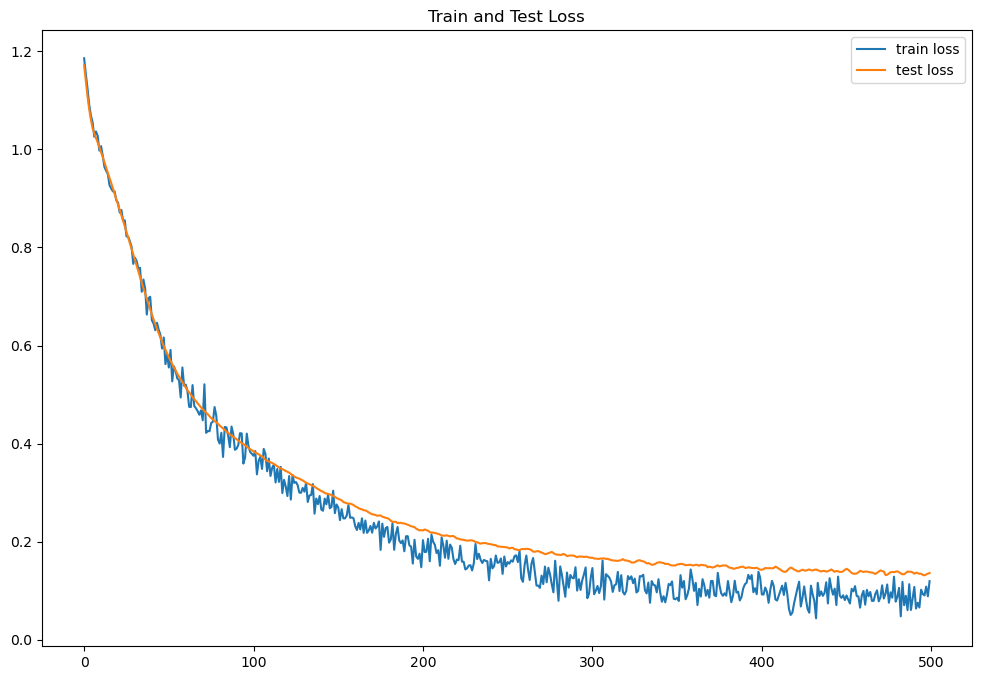

In [9]:
fig = plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='train loss')
plt.plot(test_loss, label='test loss')
plt.title("Train and Test Loss")
plt.legend()
plt.show()

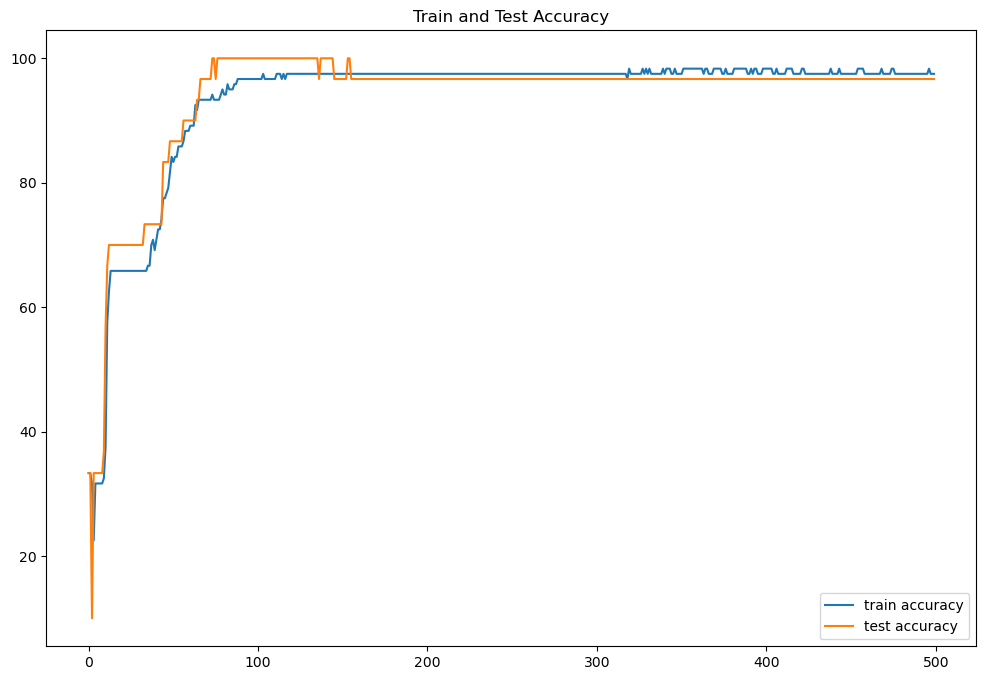

In [10]:
fig = plt.figure(figsize=(12, 8))
plt.plot(train_accuracy, label='train accuracy')
plt.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
plt.legend()
plt.show()

### Saving the model to disk, and loading it back

In [11]:
torch.save(net.state_dict(), "./2.model.pth")

In [12]:
net2 = IrisNet(4, 100, 50, 3)
net2.load_state_dict(torch.load("./2.model.pth"))

<All keys matched successfully>

In [13]:
output = net2(Variable(torch.FloatTensor([[5.1, 3.5, 1.4, 0.2]])))

In [14]:
_, predicted_class = torch.max(output.data, 1)
print('Predicted class: ', predicted_class.numpy()[0])
print('Expected class: ', 0 )

Predicted class:  0
Expected class:  0
